In [402]:
#Author: Eren Ali Aslangiray

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

## Data
#### Source from: https://pokemondb.net/pokedex/all
#### Crawled by: Sümeyye Sena Eminmollaoğlu

In [403]:
df = pd.read_csv("pokemon_data.csv")
df[40:50]

,ID,Name,HP,ATK,DEF,SP.ATK,SP.DEF,SPEED,TYPE1,TYPE2
40,41,Zubat,40,45,35,30,40,55,Poison,Flying
41,42,Golbat,75,80,70,65,75,90,Poison,Flying
42,43,Oddish,45,50,55,75,65,30,Grass,Poison
43,44,Gloom,60,65,70,85,75,40,Grass,Poison
44,45,Vileplume,75,80,85,110,90,50,Grass,Poison
45,46,Paras,35,70,55,45,55,25,Bug,Grass
46,47,Parasect,60,95,80,60,80,30,Bug,Grass
47,48,Venonat,60,55,50,40,55,45,Bug,Poison
48,49,Venomoth,70,65,60,90,75,90,Bug,Poison
49,50,Diglett,10,55,25,35,45,95,Ground,None


# Objective 1 - Finding the Best Pokemons.

#### For this task. I defined 2 rating system which is sum and hex. Sum means, getting the summation of all of the stats of pokemon with desired level. Hex means with 6 stats at desired level, algorithm will build a hexagon of these stats from 0 point and will get the area of it. 
#### With the user query, we will find first n best pokemon with respect to their type. Later on this module will be used for selecting the best counter team for your opponent.

## Formulas
#### Source from: https://bulbapedia.bulbagarden.net/wiki/Statistic

$ HP = [\frac{(2*Base + IV +[\frac{EV}{4}])* Level }{100}] + Level + 10 $



$ Other Stats = [([\frac{(2*Base + IV +[\frac{EV}{4}])* Level }{100}]+5)* Nature] $


## Functions

In [404]:
#Hp points calculator for desired lvl:
def hpcalculator(base,level,ıv=0,ev=0):
    if level ==1 or level ==0:
        return base
    else:
        hp = ((((2.0*base+ıv+(ev/4.0))*level)/100.0) + level + 10.0) + base
        return int(hp)

#Other stats calculator for desird lvl:
def statcalculator(base,level,ıv=0,ev=0,nature=1):
    if level ==1 or level==0:
        return base
    else:
        stats = (((((2.0*base+ıv+(ev/4.0))*level)/100.0) + 5) * nature) + base
        return int(stats)

#Pokemon rating algorthm. Has two rating, basic sum or hex area.
def ratingmetric(stats,rating_type = "sum",plotoption = "off"):
    if rating_type == "sum":
        result = sum(stats)
        return result
    else:
        hexpoints, plot = hexagoncalculator(stats,plot=plotoption)
        return hexarea(hexpoints),plot

#Filters the database for desired pokemon type and adds a rating to each pokemon with desired lvl.
def dfratingadder(df,level,type1,type2,plotonoff = "off"):
    ratinglist_sum = []
    ratinglist_hex = []
    
    if type1 == "ALL":
        dfin = df.copy()
    else:
        if type(type1) != list:
            type1 = [type1]
        if type2 == "-":
            dfin = df.loc[df.TYPE1.isin(type1) | df.TYPE2.isin(type1)]
        else:
            if type(type2) != list:
                type2 = [type2]
            type1 = type1 + type2
            dfin = df.loc[df.TYPE1.isin(type1) & df.TYPE2.isin(type1)]
    for i in dfin.values:
        def_stats = [i[2],i[3],i[4],i[5],i[6],i[7]]
        for i in range(6):
            if i == 0:
                def_stats[i] = hpcalculator(def_stats[i],level)
            else:
                def_stats[i] = statcalculator(def_stats[i],level)
        ratesum = ratingmetric(def_stats)
        ratehex,plott = ratingmetric(def_stats,rating_type="hex",plotoption=plotonoff)
        ratinglist_sum.append(ratesum)
        ratinglist_hex.append(ratehex)
    dfin["RATING_SUM"] = ratinglist_sum
    dfin["RATING_HEX"] = ratinglist_hex
    resultdf = dfin.drop(columns = ["HP","ATK","DEF","SP.ATK","SP.DEF","SPEED"])
    return resultdf

#Filters the results and get the top n.
def filtertopn(df,level,type1="ALL",type2="-",criteria = "sum",n=3,plot="off"):
    criteria_meaning = {"sum":"RATING_SUM","hex":"RATING_HEX","battle":"RATING_BATTLE"}
    dfinside = dfratingadder(df,level,type1,type2,plotonoff=plot)
    dfoutside = dfinside.sort_values(by=criteria_meaning[criteria],ascending=False)[:n]
    return dfoutside

#Finds cos value for unit triangle
def cosvalue(angle):
    Radians = math.radians(angle)
    cos   = math.cos(Radians)
    return round(cos,2)

#Finds coordinate points for value and angle.
def pointfinder(value,angle):
    x,y = int(value*cosvalue(angle)) , int(value*cosvalue(90-angle))
    return x,y

#Calculates the hexagon points and plots if plot is on.
def hexagoncalculator(vallist,plot="off"):
    for i in range(len(vallist)):
        if i == 0:
            vallist[i] = (vallist[i],0)
        elif i == 1:
            x,y = pointfinder(vallist[i],60)
            vallist[i] = (x,y) 
        elif i == 2:
            x,y = pointfinder(vallist[i],60)
            vallist[i] = (-x,y) 
        elif i == 3:
            vallist[i] = (-1*vallist[i],0)
        elif i == 4:
            x,y = pointfinder(vallist[i],60)
            vallist[i] = (-x,-y) 
        elif i == 5:
            x,y = pointfinder(vallist[i],60)
            vallist[i] = (x,-y)
    if plot=="on":
        plot = hexagonplotter(vallist)
    return vallist,plot

#Plot func.
def hexagonplotter(vallist):
    for points in [vallist]:
        plot = plt.plot(*zip(*points+points[:1]), marker='o')
    return plot

#Hex area calculator.
def hexarea(corners):
    area = 0.0
    for i in range(6):
        j = (i+1) % 6
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

def pokemon_comparer(poke1,poke1_lvl,poke2,poke2_lvl,compara_crit = "hex",plotpref="on"):
    criteria_meaning = {"sum":"RATING_SUM","hex":"RATING_HEX"}
    poke1_stats = list(df.loc[df["Name"]==poke1].values[0][2:8])
    poke2_stats = list(df.loc[df["Name"]==poke2].values[0][2:8])
    for i in range(2):
        if i == 0:
            name = poke1
            level = poke1_lvl
            calc = poke1_stats
            color = "blue"
        else:
            name = poke2
            level = poke2_lvl
            calc = poke2_stats
            color = "orange"
        for i in range(6):
            if i == 0:
                calc[i] = hpcalculator(calc[i],level)
            else:
                calc[i] = statcalculator(calc[i],level)
        ratesum = ratingmetric(calc)
        ratehex,plott = ratingmetric(calc,rating_type="hex",plotoption=plotpref)
        print("For "+name+":")
        print("-Sum-metric:"+str(ratesum))
        print("-Hex-metric:"+str(ratehex))
    blue_patch = mpatches.Patch(color="C0", label=poke1)
    orange_patch = mpatches.Patch(color="C1", label=poke2)
    plt.legend(handles=[blue_patch,orange_patch])
    print("")
    print("Meanings of the points:")
    print("Angles; 0:HP, 60:ATK, 120:DEF, 180:SP.ATK, 240:SP.DEF, 300:SPEED")

## Filtering top-n pokemon.

,ID,Name,TYPE1,TYPE2,RATING_SUM,RATING_HEX
790,791,Solgaleo,Psychic,Steel,1325,127591.0
375,376,Metagross,Steel,Psychic,1178,101977.5
384,385,Jirachi,Steel,Psychic,1181,100532.0
436,437,Bronzong,Steel,Psychic,994,67996.0
374,375,Metang,Steel,Psychic,849,50546.0
373,374,Beldum,Steel,Psychic,627,26980.0
435,436,Bronzor,Steel,Psychic,627,19939.5


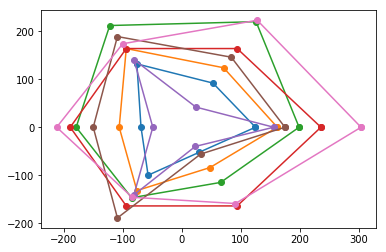

In [405]:
filtertopn(df,42,n=10, criteria="hex",plot="on",type1="Steel",type2="Psychic")

## Comparing 2 pokemon with based on their lvl.

For Charizard:
-Sum-metric:1737
-Hex-metric:216731.5
For Magmortar:
-Sum-metric:1755
-Hex-metric:218857.5

Meanings of the points:
Angles; 0:HP, 60:ATK, 120:DEF, 180:SP.ATK, 240:SP.DEF, 300:SPEED


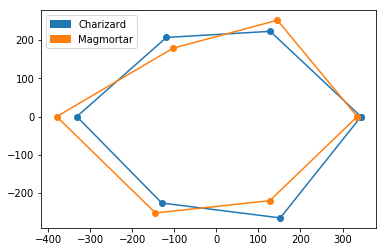

In [406]:
pokemon_comparer("Charizard",100,"Magmortar",100)

# Objective 2 - Finding the Best Counter Team.

#### For this objective.

## Pokemon Fight Mechanism:

### @Pokemon there are certain types deal better damage to certain types and also vice-versa. So here is the  table that shows the relationships. 
#### Source from: https://bulbapedia.bulbagarden.net/wiki/Type 

![Pokemon Type Efectiness](https://user-images.githubusercontent.com/36948475/59338548-3384ab00-8d0b-11e9-8f50-70fdc056aeb8.png")

### Python Implementation of Graph Above:

In [407]:
name_label_list = ["Normal","Fighting","Flying","Poison","Ground","Rock","Bug","Ghost","Steel","Fire","Water","Grass","Electric","Psychic","Ice","Dragon","Dark","Fairy"]
fight_att_table = { 0:[1,1,1,1,1,0.5,1,0,0.5,1,1,1,1,1,1,1,1,1],
                    1:[2,1,0.5,0.5,1,2,0.5,0,2,1,1,1,1,0.5,2,1,2,0.5],
                    2:[1,2,1,1,1,0.5,2,1,0.5,1,1,2,0.5,1,1,1,1,1],
                    3:[1,1,1,0.5,0.5,0.5,1,0.5,0,1,1,2,1,1,1,1,1,2],
                    4:[1,1,0,2,1,2,0.5,1,2,2,1,0.5,2,1,1,1,1,1],
                    5:[1,0.5,2,1,0.5,1,2,1,0.5,2,1,1,1,1,2,1,1,1],
                    6:[1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,2,1,2,1,1,2,0.5],
                    7:[0,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,0.5,1],
                    8:[1,1,1,1,1,2,1,1,0.5,0.5,0.5,1,0.5,1,2,1,1,2],
                    9:[1,1,1,1,1,0.5,2,1,2,0.5,0.5,2,1,1,2,0.5,1,1],
                    10:[1,1,1,1,2,2,1,1,1,2,0.5,0.5,1,1,1,0.5,1,1],
                    11:[1,1,0.5,0.5,2,2,0.5,1,0.5,0.5,2,0.5,1,1,1,0.5,1,1],
                    12:[1,1,2,1,0,1,1,1,1,1,2,0.5,0.5,1,1,0.5,1,1], 
                    13:[1,2,1,2,1,1,1,1,0.5,1,1,1,1,0.5,1,1,0,1],
                    14:[1,1,2,1,2,1,1,1,0.5,0.5,0.5,2,1,1,0.5,2,1,1],
                    15:[1,1,1,1,1,1,1,1,0.5,1,1,1,1,1,1,2,1,0],
                    16:[1,0.5,1,1,1,1,1,2,1,1,1,1,1,2,1,1,0.5,0.5],
                    17:[1,2,1,0.5,1,1,1,1,0.5,0.5,1,1,1,1,1,2,2,1]
                   }

## Functions

In [408]:
#Finds the weaknesses of opponent pokemon.
def attacker_calculator(defender_type1, defender_type2="None"):
    defender_stats = {}
    if defender_type2 == "None":
        defender1 = name_label_list.index(defender_type1)
        for i in range (18):
            x = fight_att_table[i][defender1]
            defender_stats[name_label_list[i]] = x
    else:
        defender1 = name_label_list.index(defender_type1)
        defender2 = name_label_list.index(defender_type2)
        combined_stats_list = []
        for i in range (18):
            x = fight_att_table[i][defender1]
            y = fight_att_table[i][defender2]
            x = x*y
            defender_stats[name_label_list[i]] = x
    return defender_stats

#Gets type of inputted pokemon.                                      
def type_extractor(pokename):
    type1 = df.loc[df["Name"]==pokename,"TYPE1"].iloc[0]
    type2 = df.loc[df["Name"]==pokename,"TYPE2"].iloc[0]
    return (type1,type2)

#Adds a battle rate to each pokemon for countering the opponent.
def df_battle_rate_adder(weakness_table):
    dfbattle = df.copy()
    ratinglist_battle = []
    weakness_table["None"] = 0
    for item in df.values:
        type1,type2 = item[8],item[9]
        ratinglist_battle.append(weakness_table[type1] + weakness_table[type2])
    dfbattle["RATING_BATTLE"] = ratinglist_battle
    return dfbattle

#Adds the hexarea for defining str of pokemon
def other_ratings_adder(dfin,level):
    ratinglist_hex = []
    for i in dfin.values:
        def_stats = [i[2],i[3],i[4],i[5],i[6],i[7]]
        for i in range(6):
            if i == 0:
                def_stats[i] = hpcalculator(def_stats[i],level)
            else:
                def_stats[i] = statcalculator(def_stats[i],level)
        ratehex = ratingmetric(def_stats,rating_type="hex")
        ratinglist_hex.append(ratehex)
    dfin["RATING_HEX"] = ratinglist_hex
    resultdf = dfin.drop(columns = ["HP","ATK","DEF","SP.ATK","SP.DEF","SPEED"])
    return  resultdf
    
def counter_team_finder (inlist):
    candidates_dict = {}
    for i in range(len(inlist)):
        type1,type2 = type_extractor(inlist[i][0])
        weakness = attacker_calculator(type1,type2)
        query_df = df_battle_rate_adder(weakness)
        bestrate = query_df.sort_values(['RATING_BATTLE'], ascending=[False]).values[0][-1]
        query_df = query_df[query_df["RATING_BATTLE"] == bestrate]
        candidate_poke = other_ratings_adder(query_df,inlist[i][1]).sort_values(['RATING_HEX'], ascending=[False]).values[0][1]
        candidates_dict[inlist[i]] = (candidate_poke,inlist[i][1])
    return candidates_dict

In [412]:
inlist = [("Groudon",42),("Golem",1),("Gengar",82),("Pikachu",99),("Alakazam",53),("Bulbasaur",44)]

counter_team_finder(inlist)

{('Groudon', 42): ('Cloyster', 42),
 ('Golem', 1): ('Ludicolo', 1),
 ('Gengar', 82): ('Lunala', 82),
 ('Pikachu', 99): ('Garchomp', 99),
 ('Alakazam', 53): ('Spiritomb', 53),
 ('Bulbasaur', 44): ('Ho-oh', 44)}